Welcome to week 5 of the [Noisebridge Python Class](https://github.com/audiodude/PythonClass)!

In this lesson, we will discuss SQL, which is **Structured Query Language**. We will perform the following tasks using Python:

1. Create a database from a schema file
1. Load data into the database from one or more CSV files
1. Query the data for insights
1. Write back a "report" in a CSV

Let's get started!

SQL is not considered to be a general purpose programming language (though I'm sure some weirdo somewhere has been able to use it to write programs at some point). Instead, it is a standard way of adding data to, and getting data from, a database. Different database systems, such as **SQLite**, **MySQL**, **MariaDB**, and **PostgreSQL** (just for a few) are able to be used with SQL. The slight customizations and variations of the language that each database uses is called the specific **dialect** of SQL.

We will be using **SQLite** for our examples, because it comes built in to Python and doesn't require running any additional software. The other database systems mentioned above all operate as servers, where you must run an ongoing process somewhere that manages and serves the data, and that you connect to over the network (whether the internet or the local network).

Luckily for us, Python defines a [Python Database API](https://peps.python.org/pep-0249/) which is a standard way of interacting with databases in the language. Almost all database interface libraries in Python implement database access using this **API** (Application Programming Interface, in this case a standard way of interacting with similarly specced resources). All this means that if your code is designed to interact with SQLite, you can switch your database to one of the server-based options and keep most if not all of your code as is.

SQLite databases are stored in individual files, one database per file. Inside the database, there can be multiple **tables**. Each table has a specific set of named **columns** which contain data. A database **row** is a particular set of columnar data. You can think of database rows as rows in a spreadsheet, with the columns being the columns.

For this lesson, we are considering the database for a fictional Reddit-clone called *Radish*. Think about what the table for the *links* on the site looks like. If it were a spreadsheet, it might look like this:

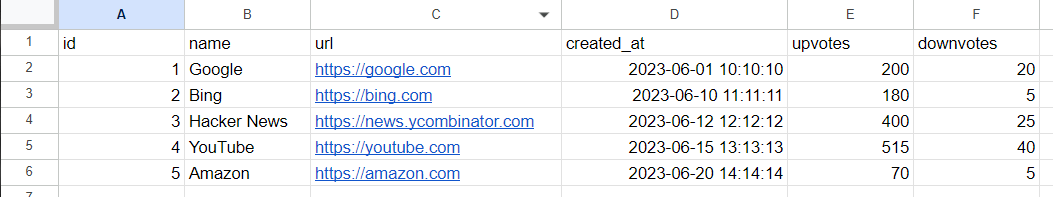

Here there is a row for each "link" in the database. This could be thought of as the "links" table. Each column holds a particular piece of data for a particular link. For example, the first link in row 2 has an id of `1` a name of `Google` and a url of `https://google.com`, among other things.

The definitions of all the tables and columns in a database is called its **schema**. Generally, we define the schema when we create the database. The schema is defined using SQL statements. For the table above, the schema would look like:

```sql
CREATE TABLE IF NOT EXISTS links (
  id INTEGER NOT NULL PRIMARY KEY,
  name VARCHAR(255),
  url TEXT,
  created_at TIMESTAMP,
  upvotes INTEGER,
  downvotes INTEGER
);
```

Here, the name of the table is `links`, which we will refer to when inserting or querying data. Each column is defined starting with it's name, then it's **datatype**. Just like in Python where there are `int`s, `str`s, etc, the columns of a database have a certain type of data that they can hold. This is used when inserting or querying, and also used for sorting.

Along with this lesson, there is a file called `schema.sql`, which contains the above create table statement as well as the following:

```sql
CREATE TABLE IF NOT EXISTS users (
  id INTEGER NOT NULL PRIMARY KEY,
  email TEXT,
  hashed_password VARCHAR(255),
  profile TEXT
);
```

Let's connect to our database using the `sqlite3` module.

In [ ]:
import sqlite3

def connect():
    # This is the file that will store our database, we can
    # name it anything we want, but it's nice to have a .sqlite
    # or .sqlite3 extension.
    return sqlite3.connect('radish.sqlite')

Once we've connected, we get a **cursor** for the database. The cursor is the object that you use to execute all queries, and has methods for executing SQL as well as getting back metadata about inserted or queried data.

In [ ]:
db = connect()

cursor = db.cursor()

# Open our schema file for reading.
# The with...as statement invokes a "context manager", which we
# saw briefly in earlier lessons when dealing with files. The main
# advantage of using a context manager is that the cursor is only
# valid inside the block, and is automatically "cleaned up" after the
# block is over, regardless of if there is any exception thrown.
with open('schema.sql', 'r') as f:
    # Execute all of the SQL statements in the schema file
    cursor.executescript(f.read())

Now we can start inserting our data. I've stored the spreadsheet above as csv file alongside this lesson, `data_links.csv`. We can read it using the Python `csv` module, which will automatically parse the data (we don't have to worry about splitting by commas or columns that have escaped values).

In [ ]:
import csv

with open('data_links.csv', 'r') as f:
    reader = csv.reader(f)
    for idx, row in enumerate(reader):
        # Skip the first row, because it contains the column names ('id,name,url...')
        if idx == 0:
            continue
        # The syntax with three ' or " indicates a '''multi-line string'''.
        # These can be used anywhere a string is used and allow for strings to
        # more easily contain newlines/line breaks. As for SQL, any amount of
        # whitespace is allowed before, after and in the middle of a statement.
        # We use the multi-line string to make our query easier to read.
        cursor.execute('''
          INSERT INTO links
            (id, name, url, created_at, upvotes, downvotes)
          VALUES
            (?, ?, ?, ?, ?, ?)
        ''', row)

So what's going on here? We create a `csv.reader` from our csv file, which we can iterate over using a for loop to get all of the rows in the csv. We use `enumerate` to get the index of each row (assigned to `idx`) along with the row data. This is useful so that we can skip the first row, which contains the names of the columns. Finally, for each row we use the `INSERT INTO` SQL statement, which takes a table name (`links`), a list of columns to insert for (`(id, name, url, created_at, upvotes, downvotes)` -- any non-specified columns are skipped and given their default value, which is usually `NULL` or 0), and finally a list of values to insert.

Note that we didn't specify the values directly, we used the placeholder `?` and then passed an array of values to populate the query with. **If there is ANYTHING you learn from today's lesson, it's that you should always, ALWAYS use placeholders to insert data into a SQL database!**. The alternative would be to use string concatenation, or Python format strings directly:

```python
cursor.execute('''
  INSERT INTO links
    (id, name, url, created_at, upvotes, downvotes)
  VALUES
    (
''' + row[0] + ', ' + row[1] ... )
```

**This will cause your code to be subject to SQL injection**. You can read more [here](https://learn.microsoft.com/en-us/sql/relational-databases/security/sql-injection?view=sql-server-ver16), [here](https://en.wikipedia.org/wiki/SQL_injection) and [here](https://www.vice.com/en/article/aekzez/the-history-of-sql-injection-the-hack-that-will-never-go-away).

Now that we have data in the database, we can query it in various ways. By running a SQL `SELECT` statement, we can get all of the URLs of our links:

In [ ]:
cursor.execute('SELECT url FROM links')
data = cursor.fetchall()
print(data)

Notice that the `fetchall()` method returns a list, and in each list, there is a tuple of values. This is always the case, no matter if you select one value (as we did here, `url`) or many. *How would you access the url of the second item from the `data` variable?*

In [ ]:
cursor.execute('SELECT name, url FROM links')
data = cursor.fetchall()
# Use a list comprehension to construct a dictionary mapping
# link names to their URL. The syntax dict([(key1, value1), (key2, value2), ...])
# Creates a dictionary from an iterable where the first value of each item is
# the key and the second item is the value.
print(dict([(row[0], row[1]) for row in data]))